# Аналитика данных сервиса по продаже билетов

### В рамках данного проекта у нас есть информация об использовании сервиса по продаже билетов. Нам предстоит изучить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

# Оглавление

1. [Знакомство с данными и предобработка](#знакомство)  
2. [Анализ данных](#анализ)  
    2.1 [Продукт](#продукт)  
    2.2 [Продажи](#продажи)  
    2.3 [Маркетинг](#маркетинг)  
3. [Общий вывод](#вывод)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
orders = pd.read_csv('/datasets/orders_log.csv')

In [3]:
costs = pd.read_csv('/datasets/costs.csv')

In [4]:
visits = pd.read_csv('/datasets/visits_log.csv')

# 1. Знакомство с данными и предобработка <a name="знакомство"></a>

### Таблица orders

In [5]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


В данной таблице хранятся данные о заказах, указана дата заказа, сумма и уникальный айди пользователя. Заменим названия столбцов, чтобы в дальнейшем было удобнее к ним обращаться

In [6]:
orders.columns = ['date', 'revenue', 'uid']

In [7]:
orders.head()

,date,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [8]:
orders[orders.revenue < 0]

,date,revenue,uid


Отрицательные значения выручки отсутствуют, данные корректны

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
date       50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


пропусков нет, изменим формат даты и выделим столбец с месяцем

In [10]:
orders['order_date'] = orders.date.astype('datetime64[M]')

In [11]:
orders['date'] = pd.to_datetime(orders.date)

### Таблица visits

In [12]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


В данной таблице хранятся данные о пользовательских сессиях. Есть информация о типе устройства, начале и конце сессии, источнике траффика и уникальный айди пользователя. Так же заменим названия столбцов

In [13]:
visits.columns = ['device', 'end_time', 'source_id', 'start_time', 'uid']

In [14]:
visits.head()

,device,end_time,source_id,start_time,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [15]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device        359400 non-null object
end_time      359400 non-null object
source_id     359400 non-null int64
start_time    359400 non-null object
uid           359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Пропусков нет

In [16]:
visits.start_time.min()


'2017-06-01 00:01:00'

In [17]:
visits.start_time.max()

'2018-05-31 23:59:00'

Имеются данные с 1 июня 2017 года по 31 мая 2018 года

Выделим отдельными столбцами столбцы с датами, которые пригодятся для анализа

In [18]:
visits['end_time'] = pd.to_datetime(visits.end_time)

In [19]:
visits['start_time'] = pd.to_datetime(visits.start_time)

In [20]:
visits['start_datetime'] = visits.start_time.astype('datetime64[D]')

In [21]:
visits['end_datetime'] = visits.end_time.astype('datetime64[D]')

In [22]:
visits.head()

,device,end_time,source_id,start_time,uid,start_datetime,end_datetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-27


In [23]:
visits['day'] = visits.start_datetime.dt.day

In [24]:
visits['week'] = visits.start_datetime.dt.week

In [25]:
visits['year'] = visits.start_datetime.dt.year

In [26]:
visits['month'] = visits.start_datetime.dt.month

In [27]:
visits.head()

,device,end_time,source_id,start_time,uid,start_datetime,end_datetime,day,week,year,month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-20,20,51,2017,12
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,19,8,2018,2
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,1,26,2017,7
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-20,20,20,2018,5
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-27,27,52,2017,12


### таблица costs

In [28]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


В последней таблице содержится информация об источниках траффика и затратах на привлечение траффика через эти источники. Так же заменяем названия столбцов

In [29]:
costs.columns = ['source_id', 'cost_date', 'costs']

In [30]:
costs['cost_date'] = pd.to_datetime(costs.cost_date)

In [31]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
cost_date    2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [32]:
costs['source_id'].value_counts()

5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

Пропусков нет

### У нас есть три таблицы, содержащие данные о пользовательских сессиях, покупках и источнике привлечения и затратах на привлечение. Были изменены форматы столбцов с датами и на их основе выведены новые столбцы для дальнейшего удобства во время анализа

# 2. Анализ данных <a name="анализ"></a>

## 2.1. Продукт <a name="продукт"></a>

### Сколько длится одна сессия?

In [33]:
visits.head()

,device,end_time,source_id,start_time,uid,start_datetime,end_datetime,day,week,year,month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-20,20,51,2017,12
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,19,8,2018,2
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,1,26,2017,7
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-20,20,20,2018,5
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-27,27,52,2017,12


In [34]:
visits['session_time'] =(visits.end_time.astype('datetime64') - visits.start_time.astype('datetime64')) / np.timedelta64(1, 's')

In [35]:
visits.head()

,device,end_time,source_id,start_time,uid,start_datetime,end_datetime,day,week,year,month,session_time
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-20,20,51,2017,12,1080.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,19,8,2018,2,1680.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,1,26,2017,7,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-20,20,20,2018,5,1440.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-27,27,52,2017,12,0.0


Есть сессии, длительность которых составляет 0 секунд. Возможно, пользователям не удалось воспользоваться приложением / сайтом, либо время завершения сессии не определилось системой.

Посмотрим, на каких устройствах была эта проблема

In [36]:
zero = visits[visits.session_time == 0.0]


In [37]:
zero.head()


,device,end_time,source_id,start_time,uid,start_datetime,end_datetime,day,week,year,month,session_time
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,1,26,2017,7,0.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-27,27,52,2017,12,0.0
28,desktop,2017-11-09 15:53:00,4,2017-11-09 15:53:00,17892541477379911957,2017-11-09,2017-11-09,9,45,2017,11,0.0
32,desktop,2017-11-30 12:29:00,4,2017-11-30 12:29:00,13410401624913285510,2017-11-30,2017-11-30,30,48,2017,11,0.0
54,desktop,2018-02-23 16:52:00,10,2018-02-23 16:52:00,13423278602430425332,2018-02-23,2018-02-23,23,8,2018,2,0.0


In [38]:
zero.device.value_counts()


desktop    23689
touch      12105
Name: device, dtype: int64

В 23680 сессиях на десктопах и 12105 сессиях на телефонах были нулевые сессии


In [39]:
zero.groupby('device').agg({'uid' : 'nunique'})


,uid
device,
desktop,21596
touch,11470


В основном это наблюдалось у разных пользователей, у некоторых - более 1 раза


In [40]:
visits = visits[visits.session_time > 0.0]


In [41]:
visits.session_time.describe()


count    323604.000000
mean        714.169516
std        1026.349417
min          19.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       42660.000000
Name: session_time, dtype: float64

Очень большое максимальное значение и разница между медианой и средним.

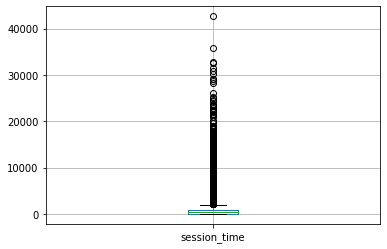

In [42]:
visits.boxplot('session_time')


Очень много выбросов с большой продолжительностью сессий

In [43]:
visits.head()

,device,end_time,source_id,start_time,uid,start_datetime,end_datetime,day,week,year,month,session_time
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-20,20,51,2017,12,1080.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,19,8,2018,2,1680.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-20,20,20,2018,5,1440.0
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017-09-03,3,35,2017,9,60.0
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-30,2018-01-30,30,5,2018,1,3360.0


In [44]:
visits['session_time'] = visits['session_time'].astype('int64')

In [45]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323604 entries, 0 to 359399
Data columns (total 12 columns):
device            323604 non-null object
end_time          323604 non-null datetime64[ns]
source_id         323604 non-null int64
start_time        323604 non-null datetime64[ns]
uid               323604 non-null uint64
start_datetime    323604 non-null datetime64[ns]
end_datetime      323604 non-null datetime64[ns]
day               323604 non-null int64
week              323604 non-null int64
year              323604 non-null int64
month             323604 non-null int64
session_time      323604 non-null int64
dtypes: datetime64[ns](4), int64(6), object(1), uint64(1)
memory usage: 32.1+ MB


Посмотрим, как складывается распределение времени сессии в целом и на разных платформах

Text(0.5, 0, 'секунд')

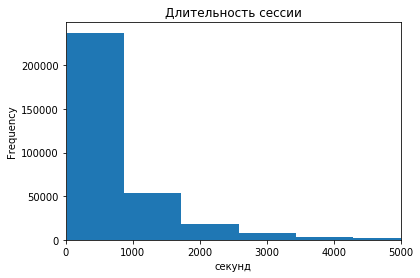

In [46]:
visits.session_time.plot(kind = 'hist',bins = 50, xlim = (0,5000), title = 'Длительность сессии').set_xlabel('секунд')




In [47]:
visits_desk = visits[visits.device == 'desktop']

Text(0.5, 0, 'секунд')

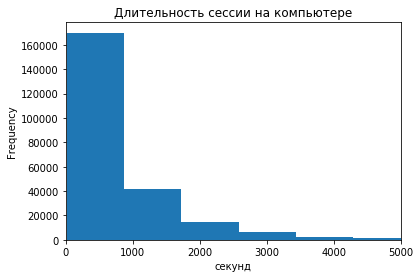

In [48]:
visits_desk.session_time.plot(kind = 'hist', bins = 50, xlim = (0,5000), title = 'Длительность сессии на компьютере').set_xlabel('секунд')


In [49]:
visits_touch = visits[visits.device == 'touch']

Text(0.5, 0, 'секунд')

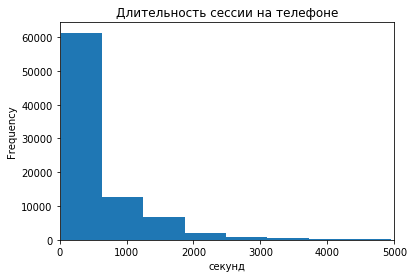

In [50]:
visits_touch.session_time.plot(kind = 'hist', bins = 50, xlim = (0,5000), title = 'Длительность сессии на телефоне').set_xlabel('секунд')

В целом, распределение длительности сессии одинаково вне зависимости от платформы и составляет в большинстве случаев менее 4 минут, основная доля пользователей тратит до 7 минут на одну сессию

### Сколько людей пользуются в день, неделю, месяц?


Посчитаем метрики DAU, WAU, MAU (кол-во уникальных пользователей в день/неделю/месяц) в целом и в разбивке по платформам 

In [51]:
dau = visits.groupby(['device', 'start_datetime']).agg({'uid': 'nunique'})


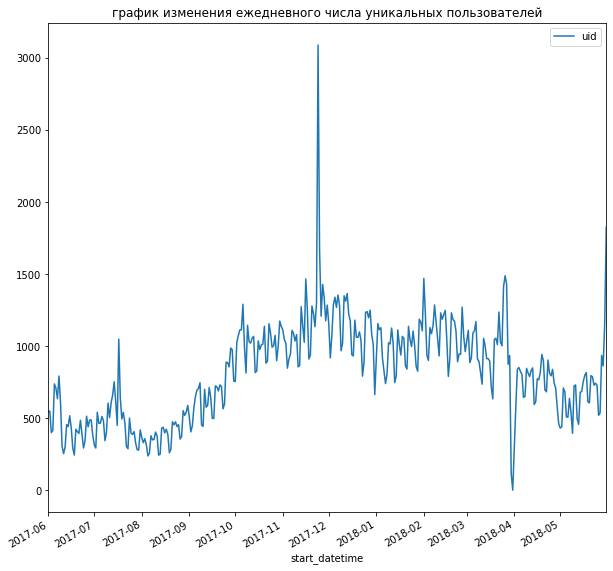

In [52]:
visits.groupby('start_datetime').agg({'uid': 'nunique'}).plot(figsize = (10,10), title = 'график изменения ежедневного числа уникальных пользователей')

видим, что был скачок активности в конце ноября и просадка в апреле

In [53]:
dau_pivot = dau.pivot_table(index = 'device', values = 'uid', aggfunc = 'mean')
dau_pivot

,uid
device,
desktop,599.750000
touch,221.460055


Пользователей desktop в 2.5 раза больше, чем touch

In [54]:
wau = visits.groupby(['device','year','week']).agg({'uid': 'nunique'})


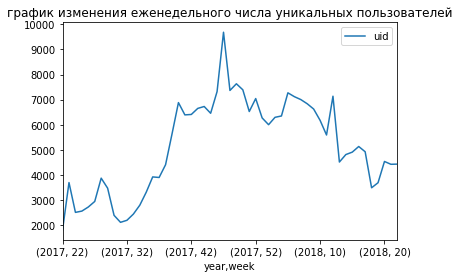

In [55]:
visits.groupby(['year','week']).agg({'uid': 'nunique'}).plot(title = 'график изменения еженедельного числа уникальных пользователей')

График также демонстрирует рост кол-ва уникальных пользователей к октября и спадом к маю 2018го

In [56]:
wau_pivot = wau.pivot_table(index = 'device', values = 'uid', aggfunc = 'mean')
wau_pivot

,uid
device,
desktop,3756.754717
touch,1433.981132


In [57]:
mau = visits.groupby(['device','year','month']).agg({'uid': 'nunique'})

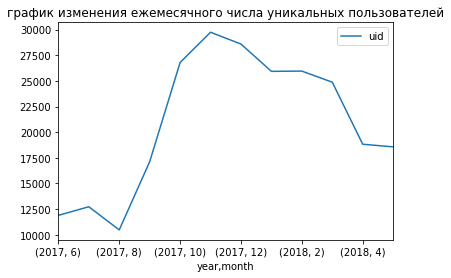

In [58]:
visits.groupby(['year','month']).agg({'uid': 'nunique'}).plot(title = 'график изменения ежемесячного числа уникальных пользователей')

In [59]:
mau_pivot = mau.pivot_table(index = 'device', values = 'uid', aggfunc = 'mean')
mau_pivot

,uid
device,
desktop,15239.833333
touch,5999.166667


In [60]:
sticky_mau = dau_pivot / mau_pivot * 100
sticky_mau

,uid
device,
desktop,3.935410
touch,3.691514


In [61]:
sticky_wau = dau_pivot / wau_pivot * 100
sticky_wau

,uid
device,
desktop,15.964577
touch,15.443722


Довольно невысокий Sticky Factor говорит о том, что пользователи чаще пользуются сервисом 1 раз в месяц.
В целом, пользователи предпочитают десктопную версию сервиса, возможно, мобильная версия не достаточно удобная и стоит обратить на это внимание.

### Сколько сессий в день?

Посмотрим, сколько раз в день пользователи пользуются сервисом

In [62]:
session_per_day = visits.groupby(['year', 'month', 'day'])['uid'].agg(['nunique', 'count']).reset_index()

In [63]:
session_per_day.columns = ['year','month', 'day','uid_nunique','uid_count']

In [64]:
session_per_day['per_day'] = session_per_day.uid_count / session_per_day.uid_nunique

In [65]:
session_per_day.pivot_table(index = ['year', 'month'], values = 'per_day', aggfunc = 'mean')

per_day
year month          
2017 6      1.075282
     7      1.076498
     8      1.067159
     9      1.075315
     10     1.077202
     11     1.093090
     12     1.089026
2018 1      1.086424
     2      1.090498
     3      1.087358
     4      1.079402
     5      1.087364

Показатель стабильно близок к 1. Либо пользователи успевают совершить все необходимые действия и реализовать свою потребность за одну сессию, либо сервис недостаточно интересен, чтобы пользоваться им чаще

### Как часто люди возвращаются

Посмотрим на Retention Rate, распределив пользователей по когортам на основе месяца, когда была совершена первая сессия.

In [66]:
visits.head()

,device,end_time,source_id,start_time,uid,start_datetime,end_datetime,day,week,year,month,session_time
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-20,20,51,2017,12,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,19,8,2018,2,1680
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-20,20,20,2018,5,1440
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017-09-03,3,35,2017,9,60
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-30,2018-01-30,30,5,2018,1,3360


In [67]:
first_visit_date = visits.groupby(['uid'])['start_datetime'].min()

In [68]:
first_visit_date.name = 'first_visit_date'

In [69]:
visits = visits.join(first_visit_date,on='uid') 

In [70]:
visits['start_month'] = visits.start_time.astype('datetime64[M]')
visits['first_visit_date'] = visits.first_visit_date.astype('datetime64[M]')

In [71]:
visits.head()

,device,end_time,source_id,start_time,uid,start_datetime,end_datetime,day,week,year,month,session_time,first_visit_date,start_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-20,20,51,2017,12,1080,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,19,8,2018,2,1680,2018-02-01,2018-02-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-20,20,20,2018,5,1440,2018-03-01,2018-05-01
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017-09-03,3,35,2017,9,60,2017-09-01,2017-09-01
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-30,2018-01-30,30,5,2018,1,3360,2017-06-01,2018-01-01


In [72]:
visits['cohort_lifetime'] = (visits['start_month'] - visits['first_visit_date']) / np.timedelta64(1,'M')


In [73]:
visits['cohort_lifetime_rounded'] = visits['cohort_lifetime'].apply(np.round).astype('int64')

In [74]:
visits.head()

,device,end_time,source_id,start_time,uid,start_datetime,end_datetime,day,week,year,month,session_time,first_visit_date,start_month,cohort_lifetime,cohort_lifetime_rounded
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-20,20,51,2017,12,1080,2017-12-01,2017-12-01,0.000000,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,19,8,2018,2,1680,2018-02-01,2018-02-01,0.000000,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-20,20,20,2018,5,1440,2018-03-01,2018-05-01,2.004148,2
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017-09-03,3,35,2017,9,60,2017-09-01,2017-09-01,0.000000,0
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-30,2018-01-30,30,5,2018,1,3360,2017-06-01,2018-01-01,7.030945,7


In [75]:
visits_cohorts = visits.groupby(['first_visit_date','cohort_lifetime_rounded']).agg({'uid':'nunique'}).reset_index() 

In [76]:
null_users = visits_cohorts[visits_cohorts['cohort_lifetime_rounded'] == 0][['first_visit_date','uid']]
null_users

,first_visit_date,uid
0,2017-06-01,11885
12,2017-07-01,11825
23,2017-08-01,9214
33,2017-09-01,15125
42,2017-10-01,23538
50,2017-11-01,24852
57,2017-12-01,23030
63,2018-01-01,20573
68,2018-02-01,20173
72,2018-03-01,18793


In [77]:
null_users = null_users.rename(columns={'uid':'cohort_users'}) 

In [78]:
visits_cohorts = visits_cohorts.merge(null_users,on='first_visit_date') 

In [79]:
visits_cohorts['retention'] = visits_cohorts['uid']/visits_cohorts['cohort_users'] 

In [80]:
visits_cohorts

,first_visit_date,cohort_lifetime_rounded,uid,cohort_users,retention
0,2017-06-01,0,11885,11885,1.000000
1,2017-06-01,1,900,11885,0.075726
2,2017-06-01,2,606,11885,0.050989
3,2017-06-01,3,710,11885,0.059739
4,2017-06-01,4,777,11885,0.065377
...,...,...,...,...,...
73,2018-03-01,1,766,18793,0.040760
74,2018-03-01,2,480,18793,0.025541
75,2018-04-01,0,14215,14215,1.000000
76,2018-04-01,1,675,14215,0.047485


In [81]:
visits_retention_pivot = visits_cohorts.pivot_table(index='first_visit_date',columns='cohort_lifetime_rounded',values='retention',aggfunc='sum') 

In [82]:
visits_retention_pivot

cohort_lifetime_rounded,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_date,,,,,,,,,,,,
2017-06-01,1.0,0.075726,0.050989,0.059739,0.065377,0.067480,0.057720,0.056121,0.050989,0.049727,0.038115,0.043921
2017-07-01,1.0,0.054545,0.050402,0.055645,0.056660,0.046512,0.044059,0.044059,0.037886,0.027315,0.027061,NaN
2017-08-01,1.0,0.074452,0.060451,0.060451,0.047970,0.041459,0.036249,0.037660,0.027133,0.024745,NaN,NaN
2017-09-01,1.0,0.083570,0.067769,0.049322,0.038083,0.036959,0.035372,0.022876,0.022744,NaN,NaN,NaN
2017-10-01,1.0,0.078129,0.050811,0.037811,0.033648,0.031184,0.020775,0.019798,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078183,0.042733,0.037824,0.032593,0.021729,0.020602,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.054668,0.036518,0.030178,0.019453,0.017716,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.057794,0.037817,0.024352,0.019249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.056561,0.024290,0.019184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
visits_retention_pivot.loc['mean'] = visits_retention_pivot.mean()

In [84]:
visits_retention_pivot

cohort_lifetime_rounded,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_date,,,,,,,,,,,,
2017-06-01 00:00:00,1.0,0.075726,0.050989,0.059739,0.065377,0.067480,0.057720,0.056121,0.050989,0.049727,0.038115,0.043921
2017-07-01 00:00:00,1.0,0.054545,0.050402,0.055645,0.056660,0.046512,0.044059,0.044059,0.037886,0.027315,0.027061,NaN
2017-08-01 00:00:00,1.0,0.074452,0.060451,0.060451,0.047970,0.041459,0.036249,0.037660,0.027133,0.024745,NaN,NaN
2017-09-01 00:00:00,1.0,0.083570,0.067769,0.049322,0.038083,0.036959,0.035372,0.022876,0.022744,NaN,NaN,NaN
2017-10-01 00:00:00,1.0,0.078129,0.050811,0.037811,0.033648,0.031184,0.020775,0.019798,NaN,NaN,NaN,NaN
2017-11-01 00:00:00,1.0,0.078183,0.042733,0.037824,0.032593,0.021729,0.020602,NaN,NaN,NaN,NaN,NaN
2017-12-01 00:00:00,1.0,0.054668,0.036518,0.030178,0.019453,0.017716,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:00:00,1.0,0.057794,0.037817,0.024352,0.019249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01 00:00:00,1.0,0.056561,0.024290,0.019184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


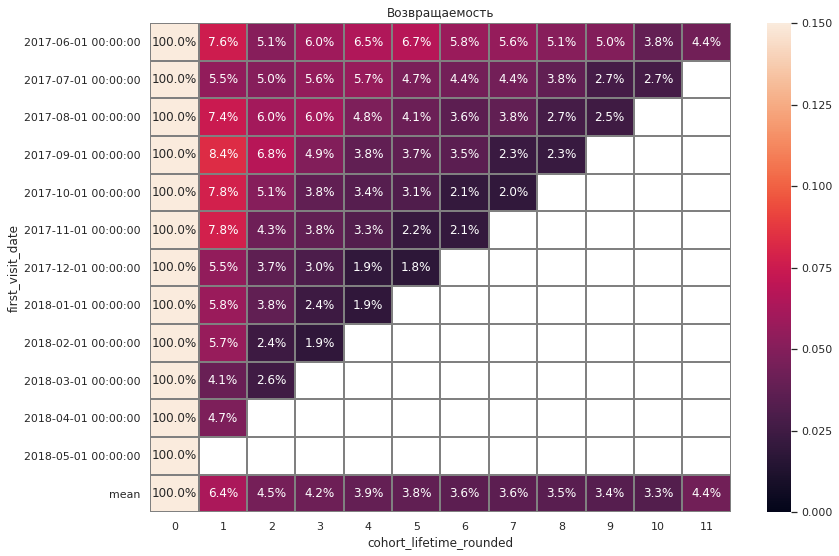

In [85]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Возвращаемость')
sns.heatmap(visits_retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin = 0.0, vmax = 0.15)

Как и было отмечено ранее, Retention Rate подтвержает тот факт, что пользователи редко возвращаются, чтобы воспользоваться сервисом. 

## Полученные метрики говорят о том, что пользователи в основном пользуются сервисом один раз, время сессии составляет до 4 минут. Кол-во пользователей возросло в конце 2017го-начале 2018 года. Большинство пользователей пользуются компьютером для доступа к платформе

## 2.2. Продажи <a name="продажи"></a>

### Когда люди начинают покупать?

выделим отдельно дату первой покупки

In [86]:
orders.head()

,date,revenue,uid,order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [87]:
first_orders = orders.groupby('uid')['date'].min()

In [88]:
first_orders.name = 'first_order_date'

In [89]:
first_orders.head()

uid
313578113262317    2018-01-03 21:51:00
1575281904278712   2017-06-03 10:13:00
2429014661409475   2017-10-11 18:33:00
2464366381792757   2018-01-28 15:54:00
2551852515556206   2017-11-24 10:14:00
Name: first_order_date, dtype: datetime64[ns]

In [90]:
orders = orders.join(first_orders,on='uid')

In [91]:
orders.head()

,date,revenue,uid,order_date,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00


In [92]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 5 columns):
date                50415 non-null datetime64[ns]
revenue             50415 non-null float64
uid                 50415 non-null uint64
order_date          50415 non-null datetime64[ns]
first_order_date    50415 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(1), uint64(1)
memory usage: 1.9 MB


In [93]:
orders['first_order_month'] = orders.first_order_date.astype('datetime64[M]')

In [94]:
orders.head()

,date,revenue,uid,order_date,first_order_date,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01


И посмотрим, сколько времени проходит с момента первой сессии до первой покупки

In [95]:
first_visits = visits.groupby('uid').agg({'start_time': 'min'})

In [96]:
firstorders = orders.groupby('uid').agg({'date': 'min'})

In [97]:
firstorders = firstorders.merge(first_visits, on = 'uid')

In [98]:
firstorders['first_order_date'] = pd.to_datetime(firstorders['date'])
firstorders['start_time'] = pd.to_datetime(firstorders['start_time'])

In [99]:
firstorders['delta'] = (firstorders['first_order_date'] - firstorders['start_time'])
firstorders['delta'] = firstorders['delta'].dt.seconds

In [100]:
firstorders.head()

,date,start_time,first_order_date,delta
uid,,,,
313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,2018-01-03 21:51:00,82920
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,2017-06-03 10:13:00,0
2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,2017-10-11 18:33:00,4740
2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,2018-01-28 15:54:00,71040
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,2017-11-24 10:14:00,0


In [101]:
firstorders['first_visit_month'] = firstorders.start_time.astype('datetime64[M]')

In [102]:
delta_sec = firstorders.groupby('first_visit_month')['delta'].mean().reset_index()
delta_sec.columns = ['first_visit_month', 'deltasec']


In [103]:
delta_sec['deltahours'] = delta_sec.deltasec / 3600
delta_sec

,first_visit_month,deltasec,deltahours
0,2017-06-01,17850.000000,4.958333
1,2017-07-01,17761.400584,4.933722
2,2017-08-01,16729.652695,4.647126
3,2017-09-01,17661.609578,4.906003
4,2017-10-01,14581.290743,4.050359
5,2017-11-01,16689.505938,4.635974
6,2017-12-01,14151.513648,3.930976
7,2018-01-01,14292.229796,3.970064
8,2018-02-01,12412.191011,3.447831
9,2018-03-01,10465.648213,2.907125


In [ ]:
delta_sec.plot(kind = 'bar', x = 'first_visit_month', y = 'deltahours', title = 'через сколько совершают первую покупку')

Пользователям требуется в среднем около 5 часов, чтобы совершить покупку после того, как они впервые воспользовались сервисом. К концу представленной временной выборки этот показатель плавно снижается до 3 часов. Возможно, были какие-то интересные предложения, либо был переработан интерфейс 

### Сколько раз покупают за период? 

In [ ]:
orders.pivot_table(index='first_order_month',
    columns='order_date',
    values='uid',
    aggfunc='count') 

In [ ]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Кол-во покупок')
sns.heatmap(orders.pivot_table(index='first_order_month',
    columns='order_date',
    values='uid',
    aggfunc='count') , annot=True, fmt='.0f', linewidths=1, linecolor='gray', vmin = 0, vmax = 400)

По сводной таблице видно, что большинство пользователей совершают покупку в первый месяц пользования сервисом. И лишь малая часть совершает повторные покупки. 

In [ ]:
orders_count = orders.groupby('order_date')['uid'].count().reset_index()
orders_count.columns = ['order_date', 'uid_count']
orders_count.head()

In [ ]:
orders_count.plot(x = 'order_date', y = 'uid_count', title = 'кол-во покупок в месяц')

Всего кол-во покупок возрастает к октябрю 2017 (до +-5000 в месяц) года и держится на закрепленном уровне до весны 2018

### Средний чек

Посмотрим, как меняется средний чек по месяцам

In [ ]:
meanbill = orders.groupby('order_date').agg({'uid':['nunique','count'], 'revenue':'sum'}).reset_index()
meanbill.columns = ['order_date', 'unique_ids', 'count_ids', 'total_revenue']
meanbill.head()

In [ ]:
meanbill['revenue_per_user'] = meanbill['total_revenue'] / meanbill['count_ids'] 
meanbill['revenue_per_user'] = meanbill['revenue_per_user'].round().astype('int')

In [ ]:
meanbill.plot(x = 'order_date', y = 'revenue_per_user', title = 'изменение среднего чека')

Средний чек держится в основном на одном уровне 5 единиц с возрастанием к концу 2017 года и падением в январе 2018. Как вариант - к новогодним праздникам спрос возрастает, а после - падает.

In [ ]:
cohorts = orders.groupby(['first_order_month', 'order_date']).agg({'uid':['nunique','count'], 'revenue':'sum'}).reset_index()

In [ ]:
cohorts

In [ ]:
cohorts.columns = ['first_order_month', 'order_date', 'unique_ids', 'count_ids', 'total_revenue']

In [ ]:
cohorts.head()

In [ ]:
cohorts['revenue_per_user'] = cohorts['total_revenue'] / cohorts['count_ids'] 
cohorts['revenue_per_user'] = cohorts['revenue_per_user'].round().astype('int')

In [ ]:
cohorts.head()

In [ ]:
cohorts.pivot_table(index='first_order_month',columns='order_date',values='revenue_per_user',aggfunc='mean') 

In [ ]:
cohorts['cohort_lifetime'] = (cohorts['order_date'] - cohorts['first_order_month']) / np.timedelta64(1,'M')

In [ ]:
cohorts['cohort_lifetime'] = cohorts['cohort_lifetime'].round().astype('int')
cohorts.head()

In [ ]:
revenue_per_user_pivot = cohorts.pivot_table(index='first_order_month',columns='cohort_lifetime',values='revenue_per_user',aggfunc='mean')

In [ ]:
revenue_per_user_pivot

In [ ]:
cohorts['first_order_month'] = cohorts['first_order_month'].dt.strftime('%Y-%m')

In [ ]:
plt.figure(figsize=(13, 9))
plt.title('Средний чек покупок')
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmin = 0, vmax = 20) 

Декабрьская когорта демонстрирует рост среднего чека на 3ий месяц пользования сервисом, а сентябрьская когорта сделала рекордный чек как раз в декабре. В целом, разброс не очень большой, средний чек плавает в районе 4-6 единиц вне зависимости от когорты и времени использования сервиса. Выделяются только Сентябрьсякая и декабрьская когорты. 

## Сколько денег приносят?

Посчтиаем метрику LTV, чтобы посмотреть, сколько всего денег приносят пользователи за время пользования сервисом в зависимости от того, какой источник траффика их привлек. Для этого объединим данные имеющихся датафреймов, чтобы соединить информацию об источнике траффика и дате покупки.

In [ ]:
costs

In [ ]:
visits.info()

In [ ]:
visits.head()

In [ ]:
orders.head()

In [ ]:
sources = visits.sort_values(by = ['uid', 'start_time']).groupby('uid').agg({'source_id': 'first'})

In [ ]:
payers = orders.groupby('uid').agg({'date': 'min'}).merge(sources, on = 'uid').reset_index()
payers = payers.rename(columns = {'date': 'first_buy'})

In [ ]:
ltv = payers.merge(orders, on = 'uid')

In [ ]:
ltv['lifetime'] = ((ltv['date'] - ltv['first_buy']) / np.timedelta64(1, 'M')).round().astype(int)
ltv

In [ ]:
orders_lifetime = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'count').fillna(0)

In [ ]:
buyers_lifetime = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'uid', aggfunc = 'nunique').fillna(0)

In [ ]:
ltv = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'sum').fillna(0)

In [ ]:
ltv = ltv.cumsum(axis = 1)

In [ ]:
cohort_sizes = payers.groupby('source_id').agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})

In [ ]:
ltv = ltv.merge(cohort_sizes, on = 'source_id')

In [ ]:
ltv = ltv.div(ltv['cohort_size'], axis = 0).drop(columns = 'cohort_size')
ltv

In [ ]:
plt.figure(figsize=(13, 9))
plt.title('LTV по источникам')
sns.heatmap(ltv, annot=True, fmt='.2f', linewidths=1, linecolor='gray') 

Самые прибыльные источники траффика под номерами 1 и 2. Средний показатель у источника №5, остальные источники демонстрируют довольно низкую прибыль, самый неэффективный по этому показателю источник №10

### Пользователи впервые совершают покупку в среднем через 5 часов после первой сессии, кол-во покупок в месяц достигает в серднем примерно 5 тысяч, средний чек составляет 4-6 денежных единиц. Самые прибыльные источники трафика - источники №1 и №2

## 2.3. Маркетинг <a name="маркетинг"></a>

### Сколько денег потратили? 

In [ ]:
costs.head()

In [ ]:
costs.groupby('source_id')['costs'].sum()

In [ ]:
costs.groupby('source_id')['costs'].sum().plot(kind = 'bar', title = 'Общие затраты на каждый источник')

In [ ]:
costs.groupby('source_id')['costs'].sum().plot(kind = 'pie', figsize = (7, 7))

Больше всего затрат было на 3 источник (почти 140 тысяч), на 2, 4 и 5 источники от 40 до 60 тысяч и 20 тысяч на источник №1

In [ ]:
costs['month'] = costs.cost_date.astype('datetime64[M]')

In [ ]:
costs_month_sum = costs.groupby(['month', 'source_id']).agg({'costs' : 'sum'}).unstack()
costs_month_sum

In [ ]:
ax = costs_month_sum.plot(figsize =(13, 13), title = 'Изменение затрат на источники траффика')
ax.legend(title = 'источник траффика')

После начала 2018 года затраты на привлечение траффика снижались. Возможно, это и повлекло снижение кол-ва пользователей и покупок, которые были отмечены нами на предыдущих этапах

### Сколько стоило привлечение

Рассчитаем метрику CAC, чтобы посмотреть величину затрат на каждого пользователя в зависимости от источника траффика

In [ ]:
cac = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index().merge(cohort_sizes.reset_index(), left_on = 'source_id', right_on='source_id')

In [ ]:
cac['cac'] = cac['costs'] / cac['cohort_size']
cac

In [ ]:
cac = cac.set_index('source_id')

In [ ]:
cac

In [ ]:
cac['cac'].plot(kind = 'bar')

Больше всего затрат приходится на источники №2 и 3, далее распределяются источники №1, 4 и 5. Похожая картина наблюдалась при расчете LTV. Посмотрим, как в итоге это отразится на ROMI

### На сколько окупились расходы?

Посмотрим на возвращаемость инвестиций, посчитав ROMI

In [ ]:
romi = ltv.merge(cac[['cac']], on = 'source_id')


In [ ]:
romi = romi.div(romi['cac'], axis = 0).drop(columns = 'cac')
romi

In [ ]:
plt.figure(figsize=(13, 9))
plt.title('ROMI по источникам')
sns.heatmap(romi, annot=True, fmt='.2f', linewidths=1, linecolor='gray') 

Первый источник окупается уже на второй месяц, источник №2 на 6ой месяц. Общая окупаемость 47 и 10% соответственно.Остальные источники траффика убыточные, только источники №5 и 9 выходят в небольшую прибыль. 

#### Затраты на привлечение трафика росли в конце 2017 и снижались с начала 2018 года, больше всего затрат было на источник №3. При этом окупаются только затраты на 1 и 2 (и немного 5 и 9) источники, а источник №3 наоборт, показывает наибольшую убыточность

# 3. Общий вывод <a name="вывод"></a>

### Были проанализированы данные об использовании сервиса в период с июня 2017 года по май 2018 года. В ходе анализа мы выяснили, что основная масса пользователей пользуются сервисом с компьютера. Большинство пользователей заходят и совершают покупку 1 раз, в первый месяц использования. В дальнейшие месяцы пользовательская активность снижается. На первую покупку, как правило, уходит 5 часов, средний чек составляет 4-6 у.е. К концу календарного года средний чек вырастает, а в начале года - снижается. Средняя продолжительность сессии соствляет до 4 минут. Также было отмечено большое кол-во нулевых сессий.
### Рост пользовательской активности наблюдался в период с осени 2017 по начало весны 2018. Согласно полученным данным, это можно связать с увеличением затрат на привлечение траффика, т.к. затраты были увеличены как раз в этот период, после чего были снижены. Больше всего затрат было на источник №3, далее по затратности идут источники №2, 4, 5 и 1. Несмотря на это, окупились только источники №1 и №2, в то время как самый затратный 3-ий источник оказался максимально убыточным.
### В связи с этим рекоммендуется:
- обратить внимание на мобильную версию сервиса. Возможно, она не достаточно удобная в сравнении с десктопной.
- проверить возможные причины возникновения нулевых сессий. Причиной может оказаться неисправность самого сервиса, либо нарушение алгоритма учета/выгрузки информации о начале/конце сессии
- проанализировать причины, по которым пользователи не хотят пользоваться сервисом более 1 раза. Может быть, сервис не достаточно удобен / мало интересных предложений
- сократить затраты на источник траффика №3 и направить эти средства на источники №1 и №2 и, возможно, №5 и №9.